# Train and evaluate a 3D Convolutional Neural Network (3dCNN) to classify motor tasks

<p style='text-align: justify;'>In this notebook we create and train a 3D-Convolutional Neural Network which learns to classify different patterns of whole-brain fMRI statistical parameters (t-scores). In this first approach our goal is to train a classifier that can reliably distinguish between such whole-brain patterns for five limb movements (i.e., left/right hand, left/right foot, and tongue).

</p>

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import os, wandb, torch, time
import pandas as pd
import numpy as np
from glob import glob
from torch.utils.data import DataLoader
from torchinfo import summary
import seaborn as sns
import matplotlib.pyplot as plt

from delphi import mni_template
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.datasets import NiftiDataset
from delphi.utils.tools import ToTensor, compute_accuracy, convert_wandb_config, read_config, z_transform_volume
from delphi.utils.plots import confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

# you can find all these files in ../utils
from utils.tools import attribute_with_method, concat_stat_files, compute_mi
from utils.wandb_funcs import reset_wandb_env, wandb_plots
from utils.random import set_random_seed

from tqdm.notebook import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<p style='text-align: justify;'>To make sure that we obtain (almost) the same results for each execution we set the random seed of multiple different librabries (i.e., torch, random, numpy)</p>

In [3]:
g = set_random_seed(2020) # the project started in the year 2020, hence the seed

## Initializations

In this section, we define and initialize our required variables. We first need to define which classes we want to predict, i.e., the conditions of the motor mapper. We then define a PyTorch dataset; in this case `NiftiDataset` is a custom written Dataset-Class (see https://github.com/PhilippS893/delphi). As is common practice in machine learning projects, we split our data into a training and validation dataset (ratio=80 to 20, respectively).

Note: In case it is necessary to create a null-model, i.e., a neural network that is trained on data where the labels are randomized, one can set the parameter `shuffe_labels=False` to `True`. This is usually done to have a baseline for the null hypothesis that "everything is random".

In [4]:
class_labels = sorted(["handleft", "handright", "footleft", "footright", "tongue"])

data_test = NiftiDataset("../t-maps/test", class_labels, 0, device=DEVICE, transform=ToTensor())

# Identify the best fold

In [5]:
from utils.wandb_funcs import get_wandb_csv

In [6]:
keys_of_interest = ['group', 'job_type', 'run_name', 'test_accuracy', 'train_acc', 'valid_acc', 
                    'valid_loss', 'best_valid_epoch', 'best_valid_accuracy', 'test_loss', 'train_loss']
wandb_df = get_wandb_csv("philis893", "thesis", "first-steps-motor", keys_of_interest, job_name="CV-7folds", overwrite=True)

real_runs = wandb_df[wandb_df.job_type == "CV-7folds"]
# sort according to best_valid_accuracy (desc), test_accuracy (desc), and test_loss (asc). Take the first entry => best fold
real_runs_sorted = real_runs.sort_values(["best_valid_accuracy", "test_accuracy", "test_loss"], ascending=[False, False, True])
real_runs_sorted.head(1)

{'entity': 'philis893', 'project': 'thesis', 'filters': {'group_name': {'$regex': 'first-steps-motor.*'}, 'jobType': 'CV-7folds'}, 'order': '-created_at', '_sweeps': {}, 'client': <wandb.apis.public.RetryingClient object at 0x7f207741a3a0>, 'variables': {'project': 'thesis', 'entity': 'philis893', 'order': '-created_at', 'filters': '{"group_name": {"$regex": "first-steps-motor.*"}, "jobType": "CV-7folds"}'}, 'per_page': 50, 'objects': [], 'index': -1, 'last_response': None}


,group,job_type,run_name,test_accuracy,train_acc,valid_acc,valid_loss,best_valid_epoch,best_valid_accuracy,test_loss,train_loss
3,first-steps-motor,CV-7folds,fold-03,1.0,1.0,1.0,0.000001,59,1.0,0.000029,0.000312


In [7]:
BEST_FOLD = 3

# Analyzing the network performances

## Loss and accuracy curves for the real and shuffled labels

In [8]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

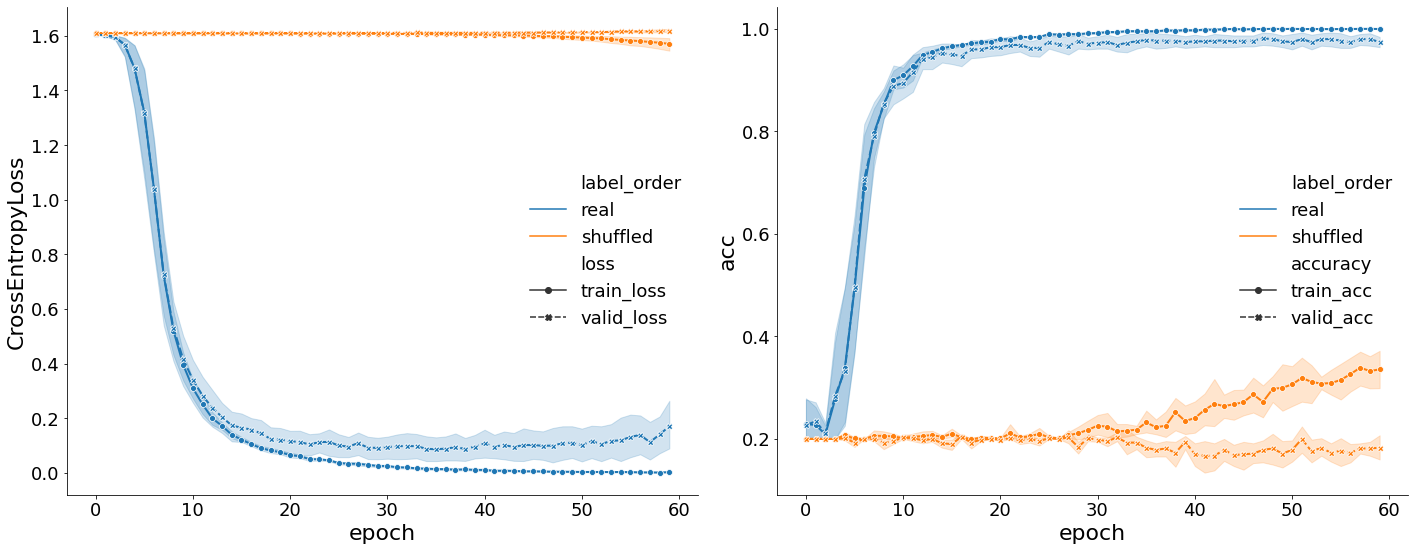

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
label_order = ["real", "shuffled"]
n_folds = 7

dfs = []
for i, order in enumerate(label_order):
    folds_real = sorted(glob(os.path.join(f"models/CV-{n_folds}folds-{order}/*fold*"))) 
    dfs.append(concat_stat_files(folds_real, "loss_acc_curves.csv"))
    dfs[i]["label_order"] = order

curves = pd.concat(dfs)
curves["epoch"] = curves.index

sns.lineplot(ax=axes[0], data=curves.melt(value_vars=["train_loss", "valid_loss"], id_vars=["epoch", "label_order"], var_name="loss", value_name="CrossEntropyLoss"), 
             x="epoch", y="CrossEntropyLoss", hue="label_order", style="loss", markers=True, markersize=6,
             linewidth=2, errorbar=("ci", 95), n_boot=5000)
sns.lineplot(ax=axes[1], data=curves.melt(value_vars=["train_acc", "valid_acc"], id_vars=["epoch", "label_order"], var_name="accuracy", value_name="acc"), 
             x="epoch", y="acc", hue="label_order", style="accuracy", markers=True, markersize=6,
             linewidth=2, errorbar=("ci", 95), n_boot=5000)

for i in range(2):
    axes[i].spines[["top", "right"]].set_visible(False);
    axes[i].legend(frameon=False, loc="center right", fontsize=18)
    
fig.tight_layout()

plt.savefig('figures/loss-acc-curves-across-folds.pdf', facecolor=fig.get_facecolor(), transparent=True)

<p style='text-align: justify;'>We can see from these lines, that the network with shuffled input-label mappings seems to begin learning to identify patterns in the shuffled data. => It overfits.
    This is corroborated by the fact that the validation accuracy stays at chance level. However, because we see an increase only training classification in 60 epochs it is not save to say that it may not also increase for the validation set with longer training durations. Thus we opted to train the same architecture with shuffled input-label mappings for 500 epochs. You can see the results below:
</p>

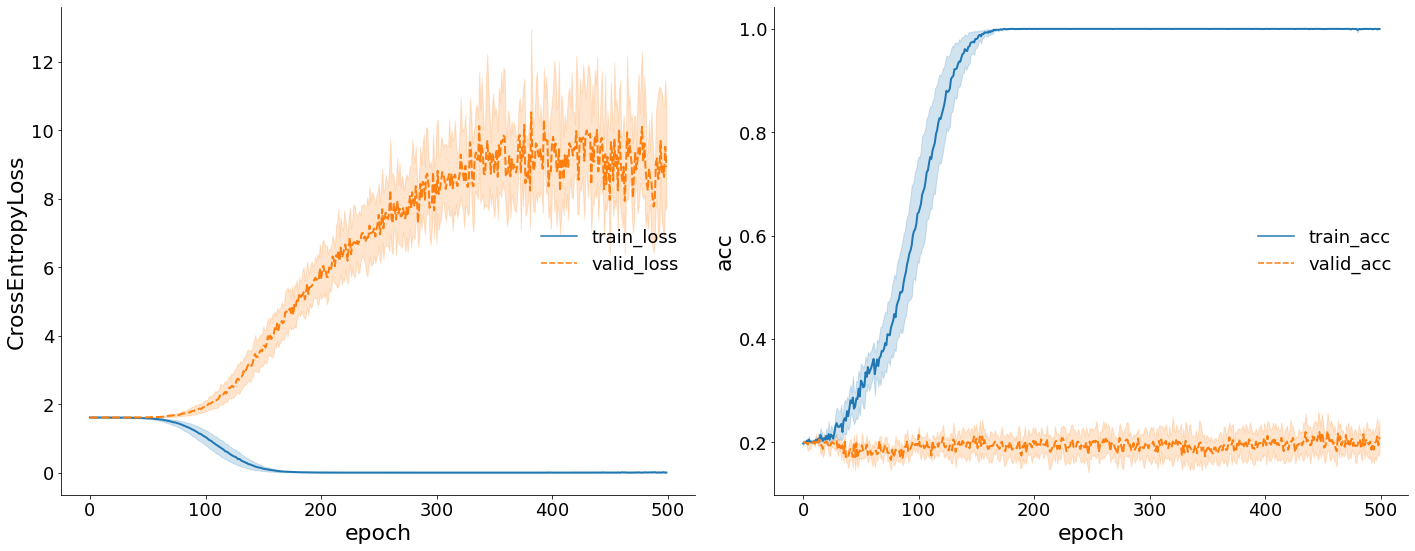

In [10]:
folds_500 = sorted(glob(os.path.join(f"models/CV-7folds-shuffled-500epochs/*fold*"))) 
curves_500 = concat_stat_files(folds_500, "loss_acc_curves.csv")
curves_500["epoch"] = curves_500.index

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
sns.lineplot(ax=axes[0], data=curves_500.melt(value_vars=["train_loss", "valid_loss"], id_vars=["epoch"], var_name="loss", value_name="CrossEntropyLoss"), 
             x="epoch", y="CrossEntropyLoss", hue="loss", style="loss", 
             linewidth=2, errorbar=("ci", 95), n_boot=5000)
sns.lineplot(ax=axes[1], data=curves_500.melt(value_vars=["train_acc", "valid_acc"], id_vars=["epoch"], var_name="accuracy", value_name="acc"), 
             x="epoch", y="acc", hue="accuracy", style="accuracy", 
             linewidth=2, errorbar=("ci", 95), n_boot=5000)

for i in range(2):
    axes[i].spines[["top", "right"]].set_visible(False);
    axes[i].legend(frameon=False, loc="center right", fontsize=18)
    
fig.tight_layout()

plt.savefig('figures/loss-acc-curves-across-folds-shuffled500.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [11]:
# compute the test classification accuracy of the folds
label_condition = ["real", "shuffled"]
stat_mats = {
    "real": [],
    "shuffled": [],
}

test_loader = DataLoader(data_test, batch_size=4, shuffle=False)

accs = np.zeros((7, 2))

for i, c in enumerate(label_condition):
    
    # get the folds
    folds = sorted(glob(os.path.join(f"models/CV-7folds-{c}", "*fold*")))
    
    for j, fold in enumerate(folds):
        
        if not os.path.isfile(os.path.join(fold, "test_stats.csv")):
            model = BrainStateClassifier3d(fold)
            model.to(DEVICE)

            with torch.no_grad():
                _ , stats = model.fit(test_loader, train=False)

            df_test = pd.DataFrame(stats.tolist(), columns=[*class_labels, *["real", "predicted"]])
            df_test.to_csv(os.path.join(fold, "test_stats.csv"), index=False)
            stat_mats[c].append(df_test)
            accs[j, i] = compute_accuracy(stats[:, -2], stats[:, -1])
        else:
            stat_mats[c].append(pd.read_csv(os.path.join(fold, "test_stats.csv")))
            accs[j, i] = compute_accuracy(stat_mats[c][j]["real"], stat_mats[c][j]["predicted"])
        

df_accs = pd.DataFrame(accs.tolist(), columns=label_condition)
df_accs.to_csv("stats/motor-accs.csv", index=False)

df_acc_transformed = np.arcsin(df_accs)
df_acc_transformed.to_csv("stats/motor-accs-transformed.csv", index=False)

<p style='text-align: justify;'>The resulting graph of the code below consists of 3 panels. The panel on the left shows the average test classification performance across all folds for the 3D CNNs trained with real and shuffled input-label mappings. The blue and violet dots represent the individual test accuracies for a given fold. The dashed line at 0.2 represents the chance level. <br>
We clearly see that the networks trained with real input-label mappings perform reliably above the chance level, whereas the networks trained with shuffled input-label mappings perform at chance level.
<br><br>
The other two panels show the confusion matrices for the real (left) and shuffled (right) input-label mappings. This is just another representation that the input-label mapping indeed matters for the network to learn to distinguish between the conditions of the motor mapper.
</p>

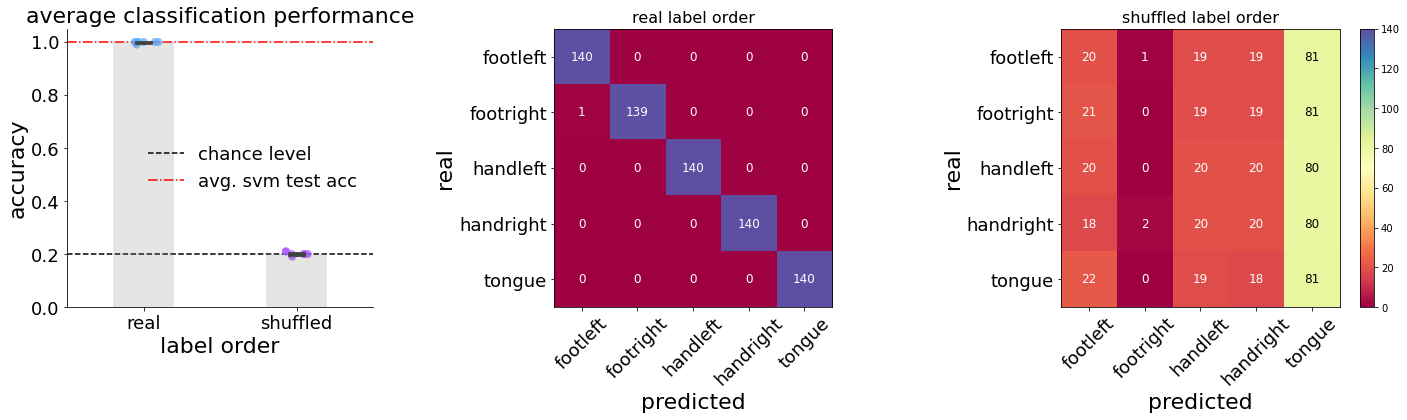

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'width_ratios': [.75, 1, 1]})

# plot the average test accuracy 
sns.barplot(ax=ax[0], data=df_accs, color=[.5,.5,.5], alpha=.2, errorbar=("ci", 95), n_boot=5000, capsize=.1, width=.4)
sns.stripplot(ax=ax[0], data=df_accs, zorder=1, alpha=.7, size=8, legend=False, palette="cool")
ax[0].axhline(0.2, linestyle="--", color="black", zorder=0, label="chance level")
ax[0].axhline(1.0, linestyle="-.", color="red", zorder=0, label="avg. svm test acc")
ax[0].set(ylabel="accuracy", xlabel="label order", title="average classification performance", ylim=[0, 1.05]);
ax[0].legend(frameon=False)
ax[0].spines[["top", "right"]].set_visible(False);


# plot the confusion matrix across all folds for the "real" label order
df = pd.concat(stat_mats["real"])
conf_mat, conf_ax = confusion_matrix(df["real"], df["predicted"], df.columns[:-2], normalize=False, ax=ax[1], **{"vmin": 0, "vmax": 140})
ax[1].set_title("real label order");

# plot the confusion matrix across all folds for the "shuffled" label order
df = pd.concat(stat_mats["shuffled"])
conf_mat, conf_ax = confusion_matrix(df["real"], df["predicted"], df.columns[:-2], normalize=False, ax=ax[2], **{"vmin": 0, "vmax": 140})
ax[2].set_title("shuffled label order");
fig.colorbar(conf_ax, ax=ax[2], )

fig.tight_layout()

plt.savefig('figures/test-performance-across-folds.pdf', facecolor=fig.get_facecolor(), transparent=True)

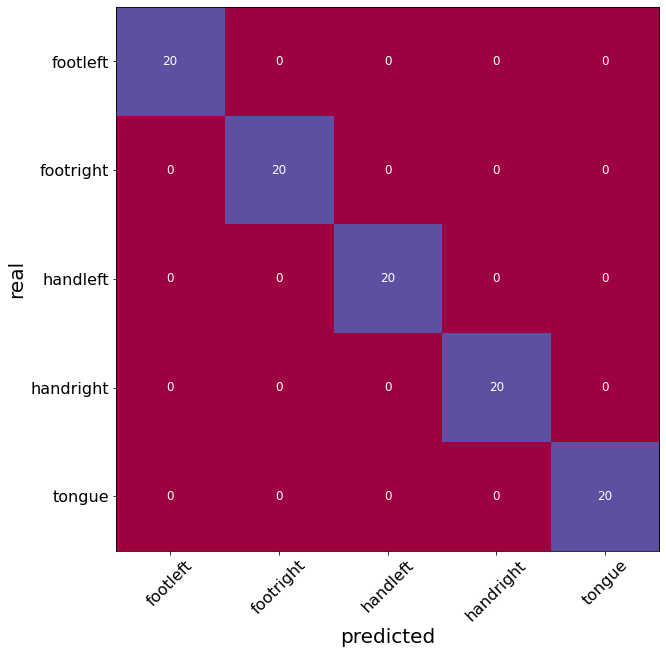

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))

df_best = pd.read_csv(f"models/CV-7folds-real/fold-{BEST_FOLD:02d}/test_stats.csv")
conf_mat, conf_ax = confusion_matrix(df_best["real"], df_best["predicted"], df_best.columns[:-2], normalize=False, ax=ax, **{"vmin": 0, "vmax": 20})

## ROC curves

In [10]:
from sklearn.preprocessing import LabelBinarizer
from utils.tools import load_data

n_classes = len(class_labels)

train_lbls = np.repeat(np.arange(n_classes), 140)
test_lbls = np.repeat(np.arange(n_classes), 20)

label_binarizer = LabelBinarizer().fit(train_lbls)
y_onehot_test = label_binarizer.transform(test_lbls)
y_onehot_test.shape  # (n_samples, n_classes)

(100, 5)

In [11]:
test_stats = pd.read_csv(f"models/CV-7folds-real/fold-{BEST_FOLD:02d}/test_stats.csv")
y_score = test_stats.iloc[:,:n_classes].to_numpy()

In [12]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, f1_score

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc  = dict(), dict(), dict()
f1_test = np.zeros(n_classes)
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

# F1-score
f1 = dict()
f1['micro'] = f1_score(test_stats.real, test_stats.predicted, average="micro")
f1['macro'] = f1_score(test_stats.real, test_stats.predicted, average="macro")

print(f"Micro-averaged F1: {f1['micro']}; Macro-averaged F1: {f1['macro']}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Micro-averaged F1: 1.0; Macro-averaged F1: 1.0


In [13]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    idc = np.where(test_stats.real==i)
    f1_test[i] = f1_score(test_stats.real.iloc[idc], test_stats.predicted.iloc[idc], average="micro")
    #print(f"F1 for {class_labels[i]}: {f1_test[i]}")
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
1.00


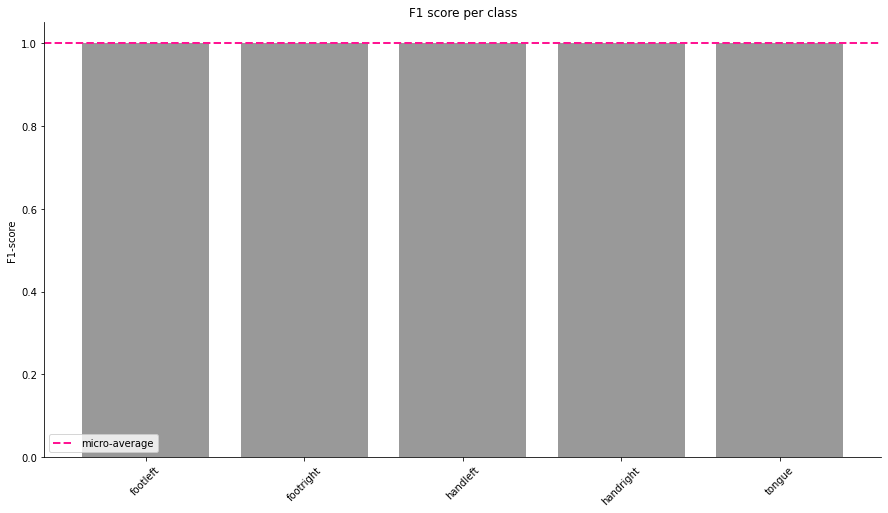

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(n_classes), f1_test, color=[.6,.6,.6])
ax.axhline(f1['micro'], linestyle="--", color="deeppink", label="micro-average", linewidth=2)
ax.set_xticks(np.arange(n_classes))
ax.set_xticklabels(class_labels, rotation=45);
ax.spines[["top", "right"]].set_visible(False);
ax.set_title("F1 score per class");
ax.set(ylabel="F1-score")
ax.legend()

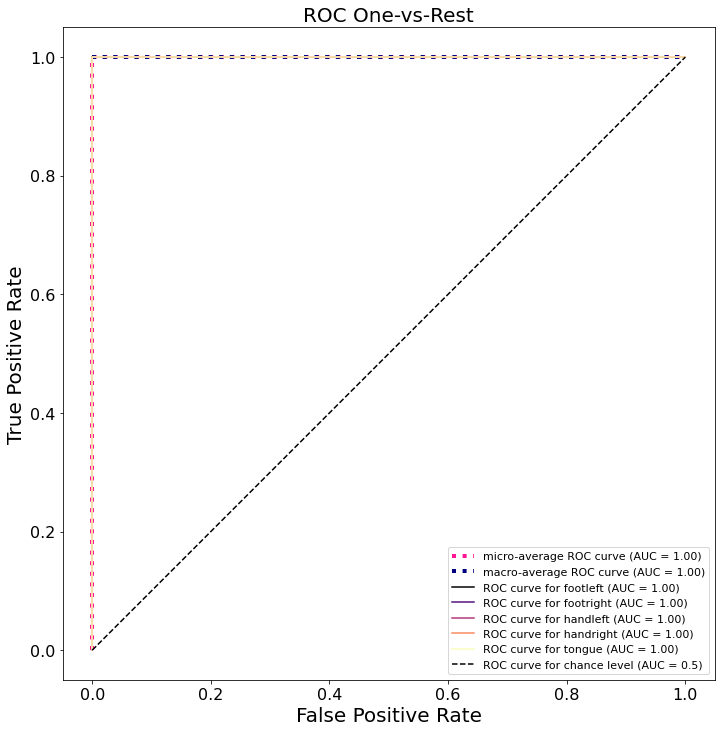

<Figure size 432x288 with 0 Axes>

In [15]:
from itertools import cycle
from matplotlib import cm

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(12, 12))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cm.get_cmap("magma", 5)
for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_labels[class_id]}",
        color=colors(class_id)[:3],
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC One-vs-Rest")
plt.legend(fontsize=11)
plt.show()

plt.savefig(f'figures/ROC-fold{BEST_FOLD:02d}.pdf', facecolor=fig.get_facecolor(), transparent=True)